<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/TD_3_void.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
%matplotlib inline

In [3]:
# utils

def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)

In [5]:
# syntax examples

range(10) # 0..9
range(1,10) # 1..9

# loop in image
def loop_sample(im):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            v = im[i,j]

# create vector, matrix
np.zeros((3,), dtype=int)
np.zeros((3,4), dtype=int)

# get element count
# im.size

# define function
def f(arg):
    return 0

In [12]:
#!pip3 install opencv-python-headless==4.5.3.56
#import cv2
#cv2.__version__


In [22]:
# execute this for all files in https://drive.google.com/open?id=14pfOYIZm31Zro5Suq8BATdHdPPivAfXN
#!pip3 install google-colab
#from google.colab import files

#install google colab library


#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

#load all the images in this drive url

url = 'https://drive.google.com/open?id=14pfOYIZm31Zro5Suq8BATdHdPPivAfXN'
import os
import requests
import re

def get_filename_from_cd(cd):
    """
    Get filename from content-disposition
    """
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0]

def download_file_from_google_drive(url, destination):
    if not os.path.exists(destination):
        print('Downloading file to {}'.format(destination))
        session = requests.Session()
        response = session.get(url, stream=True)
        token = get_confirm_token(response)
        if token:
            params = {'confirm': token}
            response = session.get(url, params=params, stream=True)
        save_response_content(response, destination)
        print('File downloaded successfully')
    else:
        print('File {} already exists'.format(destination))

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, 'wb') as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive(url, 'images.zip')


File downloaded successfully


# Plane rectification

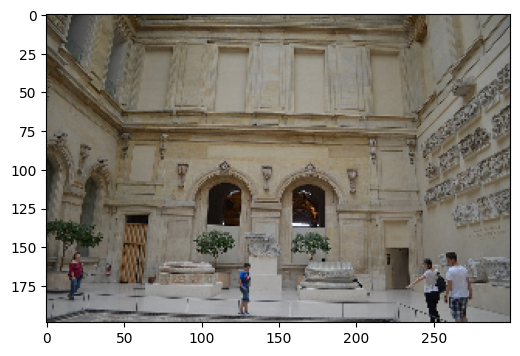

In [27]:
im = load_image('Images/mur_louvre.jpg')
subsampling = 4
display_image(im[::subsampling,::subsampling])

In [ ]:
# Exemple : ratio de hauteur entre porte de gauche et "fenetre" du haut ?



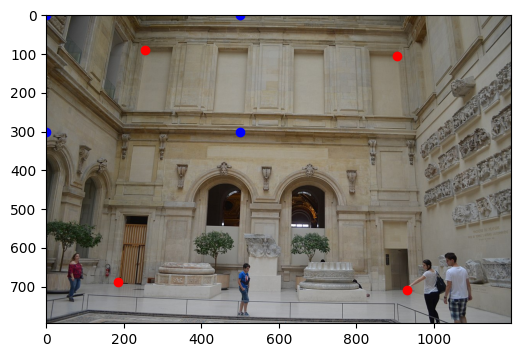

In [49]:
im_pts_sub = [(46,172), (233,177), (64,22), (226,26)]
ref_pts = [(0,0), (500,0), (0,300), (500,300)]

#Plot the points on top of the original image

im_pts = np.array(im_pts_sub) * subsampling
ref_pts = np.array(ref_pts)
plt.figure(figsize=(9,4))
plt.imshow(im)
plt.scatter(im_pts[:,0], im_pts[:,1], c='red')
plt.scatter(ref_pts[:,0], ref_pts[:,1], c='blue')



In [29]:
im_pts = im_pts_sub.copy()
for i in range(len(im_pts)):
    im_pts[i] = (subsampling*im_pts_sub[i][0], subsampling*im_pts_sub[i][1])

In [39]:
def calc_homography_DLT(ref_pts, im_pts):
    ## homography from ref_pts to im_pts
    M = np.zeros((9,9), dtype=float)
    for i in range(4):
        M[i*2+0, 0] = ref_pts[i][0]
        M[i*2+0, 1] = ref_pts[i][1]
        M[i*2+0, 2] = 1
        M[i*2+0, 6] = -im_pts[i][0]*ref_pts[i][0]
        M[i*2+0, 7] = -im_pts[i][0]*ref_pts[i][1]
        M[i*2+0, 8] = -im_pts[i][0]
        M[i*2+1, 3] = ref_pts[i][0]
        M[i*2+1, 4] = ref_pts[i][1]
        M[i*2+1, 5] = 1
        M[i*2+1, 6] = -im_pts[i][1]*ref_pts[i][0]
        M[i*2+1, 7] = -im_pts[i][1]*ref_pts[i][1]
        M[i*2+1, 8] = -im_pts[i][1]
    U, S, V = np.linalg.svd(M)
    h = V[-1,:]
    H = np.reshape(h, (3,3))
    return H



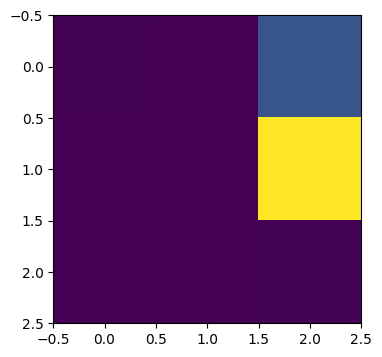

In [43]:
H = calc_homography_DLT(ref_pts, im_pts)



In [41]:
def pt_homography(H, p):
    pp = np.matmul(H, np.asarray([p[0], p[1], 1.0]))
    return 0 

In [42]:
# check homography
print("homography errors (pix)")
for i in range(4):
    print(np.linalg.norm(pt_homography(H, ref_pts[i]) - im_pts[i]))

homography errors (pix)
712.1797525905943
1170.4221460652561
270.7027890510181
909.9626365955912


In [44]:
def apply_homography(im_in, H, im_out):
    # apply homography
    for y in range(im_out.shape[0]):
        for x in range(im_out.shape[1]):
            p = np.matmul(H, np.asarray([x,y,1]))
            xi = np.clip(int(round(p[0]/p[2])),0,im_in.shape[1]-1)
            yi = np.clip(int(round(p[1]/p[2])),0,im_in.shape[0]-1)
            im_out[y,x] = im_in[yi,xi]

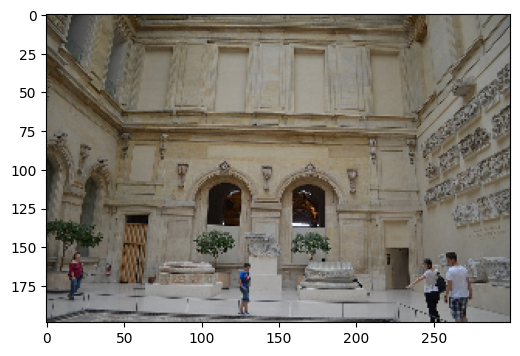

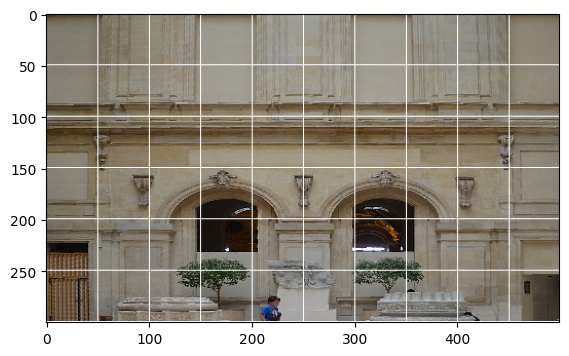

In [51]:
# apply homography
display_image(im[::subsampling,::subsampling])

im_h = np.zeros((300, 500, 3), dtype=im.dtype)
apply_homography(im, H, im_h)
# draw a grid on im_h
im_h[:,::50] = 255
im_h[::50,:] = 255
display_image(im_h[::-1])



# Stitching

In [ ]:
# images from https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/

images = []
for f in ['IMG_1786-2.jpg', 'IMG_1787-2.jpg', 'IMG_1788-2.jpg']:
    images.append(load_image(f))

plt.figure(figsize=(10,4))
for i, im in enumerate(images):
    plt.subplot(1,len(images),i+1)
    plt.axis('off')
    plt.imshow(im);
plt.tight_layout()

In [ ]:
pts = []
pts_0 = [[11,332], [98,77], [299,372], [199,553]]
pts_1 = [[461,348], [533,114], [741,401], [655,582]]
pts.append(pts_0)
pts.append(pts_1)

In [ ]:
H10 = calc_homography_DLT(pts_1, pts_0)
# define bigger im1
im1ext = np.zeros((images[1].shape[0], images[1].shape[1]*2, images[1].shape[2]), dtype=images[1].dtype)
#apply_homography(images[0], H10, im1ext)
im1ext = cv2.warpPerspective(images[0], np.linalg.inv(H10), im1ext.shape[1::-1])

In [ ]:
display_image(im1ext)

In [ ]:
mask = im1ext[:,:images[1].shape[1]] == 0
im1ext[:,:images[1].shape[1]][mask] = images[1][mask]
display_image(im1ext)

# Automated homography

## RANSAC on line

In [ ]:
sz = 100
n = 1000
n_inliers = n * 5 // 100
pts = np.random.randint(0, sz, (n,2))
# overwrite inliers
pts[:n_inliers,0] = np.random.randint(0, sz, (n_inliers,))
pts[:n_inliers,1] = np.round(pts[:n_inliers,0] * 0.1234 + 56.78)

In [ ]:
# display points
im = np.zeros((sz,sz,3), dtype=np.uint8)
im[pts[:,1],pts[:,0]] = 255
display_image(im)

In [ ]:
def pts2line(p1, p2):
    if np.linalg.norm(p1 - p2) < 1.0:
        return ((0.0,0.0), (1.0,0.0))
    u = p2 - p1
    u = u / np.linalg.norm(u)
    return (p1, u)

def linedist(line, p):
    # projection on u ortho
    return np.abs(np.dot(p - line[0], np.asarray([line[1][1], -line[1][0]])))

def RANSAC_line(pts):
    N = pts.shape[0]
    best_line = None
    best_n = 0
    best_inliers = None
    for iter in range(1000):
        ids = np.random.choice(N, 2, replace=False)
        line = 0 ##
        inliers = []
        inlier_threshold = 1.0 # Distance threshold to identify inliers with line check
        for i in range(N):
            dist = 0 ##
            if dist < inlier_threshold:
                inliers.append(pts[i])
        # print((ids, len(inliers)))
        if len(inliers) > best_n:
            0 ##
    return (best_line, best_n)

In [ ]:
found_line, found_inliers = RANSAC_line(pts)
print('inliers found %d' % found_inliers)
# get line as y = ax+b from (p,u) representation
print(found_line)
b = found_line[0][1] - found_line[1][1] * found_line[0][0] / found_line[1][0]
a = found_line[1][1] / found_line[1][0]
print('line eq y=%fx+%f' % (a,b))

In [ ]:
# draw line on image
cv2.line(im, (0,int(round(b))), (sz,int(round(a*sz+b))), color=(255,0,0))
display_image(im)

## Towards automated stitching

In [ ]:
# https://docs.opencv.org/3.4/db/d70/tutorial_akaze_matching.html

from math import sqrt

# point matching
akaze = cv2.AKAZE_create()
kpts1, desc1 = akaze.detectAndCompute(images[0], None)
kpts2, desc2 = akaze.detectAndCompute(images[1], None)
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

print('%d potential matches' % len(matched1))
matched1_np = np.asarray([(m.pt[0],m.pt[1]) for m in matched1])
matched2_np = np.asarray([(m.pt[0],m.pt[1]) for m in matched2])

# RANSAC on homographies
best_H = None
best_n = 0
best_inliers = None
for iter in range(1000):
    ids = np.random.choice(len(matched1), 4, replace=False)
    H = calc_homography_DLT(matched1_np[ids], matched2_np[ids])

    inliers1 = []
    inliers2 = []
    good_matches = []
    inlier_threshold = 2.5 # Distance threshold to identify inliers with homography check
    for i, m in enumerate(matched1):
        col = np.ones((3,1), dtype=np.float64)
        col[0:2,0] = m.pt
        pt2 = ##
        pt2 /= pt2[2,0]
        dist = ##
        if dist < inlier_threshold:
            good_matches.append(cv2.DMatch(len(inliers1), len(inliers2), 0))
            inliers1.append(matched1[i])
            inliers2.append(matched2[i])
    print((ids, len(inliers1)))
    if len(inliers1) > best_n:
        best_H = H
        best_n = len(inliers1)
        best_inliers = (inliers1,inliers2)

In [ ]:
best_n, best_H

In [ ]:
# define bigger im1
im1ext = np.zeros((images[1].shape[0], images[1].shape[1]*2, images[1].shape[2]), dtype=images[1].dtype)
#apply_homography(images[0], H10, im1ext)
im1ext = cv2.warpPerspective(images[0], best_H, im1ext.shape[1::-1])
mask = im1ext[:,:images[1].shape[1]] == 0
im1ext[:,:images[1].shape[1]][mask] = images[1][mask]
display_image(im1ext)